# Primeiros Blocos

In [1]:
import numpy as np
import pandas as pd
import os, json, pickle
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import joblib

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from collections import Counter

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, matthews_corrcoef, confusion_matrix
)

In [2]:
DATA_DIR = "data"
IN_CSV   = os.path.join(DATA_DIR, "merged_btc_features.csv")
OUT_CSV  = os.path.join(DATA_DIR, "merged_btc_features_CLEAN.csv")

df_raw = pd.read_csv(IN_CSV)
print("RAW SHAPE:", df_raw.shape)
print("RAW COLUMNS:", list(df_raw.columns)[:20], "...")

df_raw["date"] = pd.to_datetime(df_raw["date"], errors="coerce", utc=True).dt.tz_localize(None)
df_raw = df_raw.sort_values("date").reset_index(drop=True)

df = df_raw.copy()
df["target"] = (df["close"].shift(-1) > df["close"]).astype("Int64")

# Drop last row (no t+1 label)
df = df.iloc[:-1, :].copy()
df = df.sort_values("date").reset_index(drop=True)

# ---- 3) Drop non-features / metadata early ----
# These were fully NaN in your export and should not be in feature_cols
for col_to_drop in ["symbol", "interval"]:
    if col_to_drop in df.columns:
        df = df.drop(columns=[col_to_drop])

# Optionally drop 'price_usd' to avoid duplicating 'close' signal
if "price_usd" in df.columns:
    drop_price_usd = True
else:
    drop_price_usd = False

# ---- 4) Define feature set ----
drop_cols = {"date", "target"}
if drop_price_usd:
    drop_cols.add("price_usd")

feature_cols = [c for c in df.columns if c not in drop_cols]

# ---- 5) Coerce numerics & clean missing ----
for c in feature_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

before = len(df)
df[feature_cols] = df[feature_cols].ffill()#.bfill()

# Drop any rows still missing *after* ffill/bfill (usually early rolling windows)
df = df.dropna(subset=feature_cols + ["target"]).reset_index(drop=True)
after = len(df)

# ---- 6) Report & diagnostics ----
print(f"Cleaned rows: {before} → {after}")
if after > 0:
    print("Date range:", df["date"].min().date(), "→", df["date"].max().date())
else:
    print("Date range: None → None")

print("Feature count:", len(feature_cols))

# Helpful: show columns that still have NaNs (should be none after drop)
na_left = df[feature_cols + ["target"]].isna().sum()
na_left = na_left[na_left > 0].sort_values(ascending=False)
if not na_left.empty:
    print("\nResidual NaNs (should be empty):")
    print(na_left)

# If we somehow ended with zero rows, provide quick diagnostics
if after == 0:
    print("\nDIAGNOSTICS: zero rows after cleaning.")
    na_counts = df_raw.isna().sum().sort_values(ascending=False).head(25)
    print("- Top NaN counts in RAW:")
    print(na_counts)
    print("\nTop of RAW (5 rows):")
    print(df_raw.head(5))
    print("\nBottom of RAW (5 rows):")
    print(df_raw.tail(5))
    raise RuntimeError("No usable rows after target/cleaning. Check diagnostics above.")

# ---- 7) Persist the clean intermediate ----
df.to_csv(OUT_CSV, index=False)
print(f"\nSaved CLEAN dataset → {OUT_CSV}")
print("Columns (first 30):", df.columns[:30].tolist())


RAW SHAPE: (1857, 26)
RAW COLUMNS: ['date', 'open', 'high', 'low', 'close', 'volume', 'quote_volume', 'trades', 'taker_buy_base', 'taker_buy_quote', 'symbol', 'interval', 'tx_count', 'price_usd', 'fee_total_btc', 'supply_btc', 'hash_rate_x', 'active_addresses', 'difficulty', 'hash_rate_y'] ...
Cleaned rows: 1856 → 1855
Date range: 2020-10-02 → 2025-10-30
Feature count: 22

Saved CLEAN dataset → data/merged_btc_features_CLEAN.csv
Columns (first 30): ['date', 'open', 'high', 'low', 'close', 'volume', 'quote_volume', 'trades', 'taker_buy_base', 'taker_buy_quote', 'tx_count', 'price_usd', 'fee_total_btc', 'supply_btc', 'hash_rate_x', 'active_addresses', 'difficulty', 'hash_rate_y', 'blk_size_mean', 'miners_revenue_usd', 'tx_count_day', 'market_cap_usd', 'tx_volume_usd', 'nvt', 'target']


# BLOCK 3B: Split 70/15/15 + StandardScaler + NPZ (tabular e sequências)

In [3]:
DATA_DIR   = "data"
IN_CLEAN   = os.path.join(DATA_DIR, "merged_btc_features_CLEAN.csv")
OUT_SPLIT  = os.path.join(DATA_DIR, "split_boundaries.json")
OUT_SCALER = os.path.join(DATA_DIR, "scaler.pkl")
OUT_TAB    = os.path.join(DATA_DIR, "tabular_train_val_test.npz")
OUT_SEQ    = os.path.join(DATA_DIR, "sequence_train_val_test.npz")

LOOKBACK = 30
MIN_SEG  = LOOKBACK + 10  # segurança: cada split precisa pelo menos isso

# ---------- 1) Load ----------
df = pd.read_csv(IN_CLEAN, parse_dates=["date"]).sort_values("date").reset_index(drop=True)
print("CLEAN SHAPE:", df.shape)

# ---------- 2) Escolha de features ----------
drop_cols = {"date", "target", "symbol", "interval", "price_usd"} & set(df.columns)
feature_cols = [c for c in df.columns if c not in drop_cols]

# garantir numérico
for c in feature_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# checar target
if "target" not in df.columns:
    raise RuntimeError("Coluna 'target' não encontrada (deve vir do 3A).")

# eliminar linhas com NaN restantes (pós 3A já deve estar limpo)
df = df.dropna(subset=feature_cols + ["target"]).reset_index(drop=True)
N = len(df)

# ---------- 3) Split 70/15/15 com mínimos ----------
train_target = int(0.70 * N)
val_target   = int(0.15 * N)
test_target  = N - train_target - val_target

def enforce_minimums(tt, vt, tst, min_seg, total_len):
    tt = max(tt, min_seg)
    rem = total_len - tt
    vt = max(vt, min_seg)
    if vt > rem - min_seg:
        vt = max(min_seg, rem - min_seg)
    tst = total_len - tt - vt
    if tst < min_seg:
        borrow = min(min_seg - tst, tt - min_seg)
        tt -= borrow
        tst += borrow
        if tst < min_seg:
            borrow2 = min(min_seg - tst, vt - min_seg)
            vt -= borrow2
            tst += borrow2
    return tt, vt, tst

train_len, val_len, test_len = enforce_minimums(train_target, val_target, test_target, MIN_SEG, N)

train_end_idx = train_len - 1
val_end_idx   = train_len + val_len - 1

TRAIN_END = pd.Timestamp(df.loc[train_end_idx, "date"])
VAL_END   = pd.Timestamp(df.loc[val_end_idx,   "date"])

train_df = df[df["date"] <= TRAIN_END].copy()
val_df   = df[(df["date"] > TRAIN_END) & (df["date"] <= VAL_END)].copy()
test_df  = df[df["date"] > VAL_END].copy()

print("=== SPLIT INFO (70/15/15) ===")
print(f"Total rows: {N} | LOOKBACK: {LOOKBACK} | MIN_SEG: {MIN_SEG}")
print(f"Train: {len(train_df)} (≤ {TRAIN_END.date()})")
print(f"Val:   {len(val_df)} (≤ {VAL_END.date()})")
print(f"Test:  {len(test_df)} (> {VAL_END.date()})")

assert len(train_df) >= MIN_SEG and len(val_df) >= MIN_SEG and len(test_df) >= MIN_SEG, "Split mínimo não satisfeito."

# ---------- 4) Escalonamento (fit só no train) ----------
scaler = StandardScaler()
X_train_tab = scaler.fit_transform(train_df[feature_cols].values)
X_val_tab   = scaler.transform(val_df[feature_cols].values)
X_test_tab  = scaler.transform(test_df[feature_cols].values)

y_train = train_df["target"].astype(int).values
y_val   = val_df["target"].astype(int).values
y_test  = test_df["target"].astype(int).values

# ---------- 5) Construção de sequências ----------
def make_sequences(X_tab, y_vec, lookback):
    """
    Constrói janelas deslizantes alinhadas temporalmente.
    Retorna (X_seq, y_seq) onde:
      - X_seq: (n_samples, lookback, n_features)
      - y_seq: (n_samples,)
    """
    n = len(X_tab)
    Xs, ys = [], []
    for j in range(lookback-1, n):
        Xs.append(X_tab[j - lookback + 1 : j + 1, :])
        ys.append(y_vec[j])
    return np.array(Xs), np.array(ys)

X_train_seq, y_train_seq = make_sequences(X_train_tab, y_train, LOOKBACK)
X_val_seq,   y_val_seq   = make_sequences(X_val_tab,   y_val,   LOOKBACK)
X_test_seq,  y_test_seq  = make_sequences(X_test_tab,  y_test,  LOOKBACK)

# ---------- 6) Persistências ----------
with open(OUT_SPLIT, "w") as f:
    json.dump({
        "LOOKBACK": LOOKBACK,
        "TRAIN_END": TRAIN_END.strftime("%Y-%m-%d"),
        "VAL_END": VAL_END.strftime("%Y-%m-%d"),
        "FEATURE_COLS": feature_cols
    }, f, indent=2)

with open(OUT_SCALER, "wb") as f:
    pickle.dump(scaler, f)

np.savez_compressed(
    OUT_TAB,
    X_train_tab=X_train_tab, y_train=y_train,
    X_val_tab=X_val_tab,     y_val=y_val,
    X_test_tab=X_test_tab,   y_test=y_test,
    feature_cols=np.array(feature_cols, dtype=object)
)

np.savez_compressed(
    OUT_SEQ,
    X_train_seq=X_train_seq, y_train_seq=y_train_seq,
    X_val_seq=X_val_seq,     y_val_seq=y_val_seq,
    X_test_seq=X_test_seq,   y_test_seq=y_test_seq,
    feature_cols=np.array(feature_cols, dtype=object),
    lookback=np.array([LOOKBACK])
)

# ---------- 7) Relatório ----------
def shape_str(arr):
    return "None" if arr is None else str(arr.shape)

print("\n=== BLOCK 3B SUMMARY ===")
print(f"FEATURES ({len(feature_cols)}): {feature_cols}")
print("\nTABULAR:")
print(f"X_train_tab: {X_train_tab.shape} | y_train: {y_train.shape}")
print(f"X_val_tab:   {X_val_tab.shape}   | y_val:   {y_val.shape}")
print(f"X_test_tab:  {X_test_tab.shape}  | y_test:  {y_test.shape}")

print("\nSEQUENCES:")
print(f"X_train_seq: {X_train_seq.shape} | y_train_seq: {y_train_seq.shape}")
print(f"X_val_seq:   {X_val_seq.shape}   | y_val_seq:   {y_val_seq.shape}")
print(f"X_test_seq:  {X_test_seq.shape}  | y_test_seq:  {y_test_seq.shape}")

print(f"\nSaved split boundaries → {OUT_SPLIT}")
print(f"Saved scaler → {OUT_SCALER}")
print(f"Saved TABULAR NPZ → {OUT_TAB}")
print(f"Saved SEQUENCE NPZ → {OUT_SEQ}")


CLEAN SHAPE: (1855, 25)
=== SPLIT INFO (70/15/15) ===
Total rows: 1855 | LOOKBACK: 30 | MIN_SEG: 40
Train: 1298 (≤ 2024-04-21)
Val:   278 (≤ 2025-01-24)
Test:  279 (> 2025-01-24)

=== BLOCK 3B SUMMARY ===
FEATURES (22): ['open', 'high', 'low', 'close', 'volume', 'quote_volume', 'trades', 'taker_buy_base', 'taker_buy_quote', 'tx_count', 'fee_total_btc', 'supply_btc', 'hash_rate_x', 'active_addresses', 'difficulty', 'hash_rate_y', 'blk_size_mean', 'miners_revenue_usd', 'tx_count_day', 'market_cap_usd', 'tx_volume_usd', 'nvt']

TABULAR:
X_train_tab: (1298, 22) | y_train: (1298,)
X_val_tab:   (278, 22)   | y_val:   (278,)
X_test_tab:  (279, 22)  | y_test:  (279,)

SEQUENCES:
X_train_seq: (1269, 30, 22) | y_train_seq: (1269,)
X_val_seq:   (249, 30, 22)   | y_val_seq:   (249,)
X_test_seq:  (250, 30, 22)  | y_test_seq:  (250,)

Saved split boundaries → data/split_boundaries.json
Saved scaler → data/scaler.pkl
Saved TABULAR NPZ → data/tabular_train_val_test.npz
Saved SEQUENCE NPZ → data/sequen

# BLOCK 3C (v2): Suavização + Boruta com Tentative Rough Fix

In [4]:
try:
    from boruta import BorutaPy
    HAS_BORUTA = True
except Exception:
    HAS_BORUTA = False

DATA_DIR   = "data"
IN_CLEAN   = os.path.join(DATA_DIR, "merged_btc_features_CLEAN.csv")
SPLIT_JSON = os.path.join(DATA_DIR, "split_boundaries.json")

OUT_SCALER      = os.path.join(DATA_DIR, "scaler.pkl")
OUT_FEAT_TXT    = os.path.join(DATA_DIR, "selected_features.txt")
OUT_ALLFEAT_TXT = os.path.join(DATA_DIR, "feature_cols_order.txt")
OUT_SNAP_CSV    = os.path.join(DATA_DIR, "model_features_snapshot_train.csv")

SEED = 42
np.random.seed(SEED)

# ---------- Load clean data + split bounds ----------
df = pd.read_csv(IN_CLEAN, parse_dates=["date"]).sort_values("date").reset_index(drop=True)
with open(SPLIT_JSON, "r") as f:
    meta = json.load(f)

# ---------- Feature selection set ----------
drop_cols = {"date", "target"}
if "price_usd" in df.columns:
    drop_cols.add("price_usd")
feature_cols = [c for c in df.columns if c not in drop_cols]

# ---------- Suavização (EMA 7 dias) ----------
def ema_smooth(series, span=7):
    return series.ewm(span=span, adjust=False).mean()

for c in feature_cols:
    df[c] = ema_smooth(pd.to_numeric(df[c], errors="coerce"))

LOOKBACK  = int(meta["LOOKBACK"])
TRAIN_END = pd.Timestamp(meta["TRAIN_END"])
VAL_END   = pd.Timestamp(meta["VAL_END"])

train_df = df[df["date"] <= TRAIN_END].copy()
val_df   = df[(df["date"] > TRAIN_END) & (df["date"] <= VAL_END)].copy()
test_df  = df[df["date"] > VAL_END].copy()

# ---------- Scale ----------
scaler = StandardScaler()
X_train = scaler.fit_transform(train_df[feature_cols])
X_val   = scaler.transform(val_df[feature_cols])
X_test  = scaler.transform(test_df[feature_cols])

y_train = train_df["target"].astype(int).values
y_val   = val_df["target"].astype(int).values
y_test  = test_df["target"].astype(int).values

# ---------- Boruta with Tentative Rough Fix ----------
def boruta_with_rough_fix(X, y, cols):
    rf = RandomForestClassifier(
        n_estimators=1000, n_jobs=-1,
        class_weight="balanced", random_state=SEED
    )
    boruta = BorutaPy(
        estimator=rf, n_estimators="auto",
        verbose=1, random_state=SEED, max_iter=100
    )
    boruta.fit(X, y)
    confirmed = np.array(cols)[boruta.support_]
    tentative = np.array(cols)[boruta.support_weak_]
    selected = list(set(confirmed) | set(tentative))
    return selected, confirmed.tolist(), tentative.tolist()

if HAS_BORUTA:
    selected_cols, confirmed, tentative = boruta_with_rough_fix(X_train, y_train, feature_cols)
    method_used = "boruta_roughfix"
    if len(selected_cols) == 0:
        rf = RandomForestClassifier(
            n_estimators=600, n_jobs=-1,
            class_weight="balanced", random_state=SEED
        )
        rf.fit(X_train, y_train)
        order = np.argsort(rf.feature_importances_)[::-1]
        selected_cols = [feature_cols[i] for i in order[:15]]
        method_used = "rf_fallback"
else:
    rf = RandomForestClassifier(
        n_estimators=600, n_jobs=-1,
        class_weight="balanced", random_state=SEED
    )
    rf.fit(X_train, y_train)
    order = np.argsort(rf.feature_importances_)[::-1]
    selected_cols = [feature_cols[i] for i in order[:15]]
    method_used = "rf_top15"

# ---------- Persist artifacts ----------
joblib.dump(scaler, OUT_SCALER)
with open(OUT_FEAT_TXT, "w") as f:
    for c in selected_cols:
        f.write(c + "\n")
with open(OUT_ALLFEAT_TXT, "w") as f:
    for c in feature_cols:
        f.write(c + "\n")

snap = pd.DataFrame(X_train, columns=feature_cols, index=train_df.index)
snap.insert(0, "date", train_df["date"].values)
snap[selected_cols].to_csv(OUT_SNAP_CSV, index=False)

print("\n=== BLOCK 3C (v2) SUMMARY ===")
print(f"Method: {method_used}")
print(f"Selected ({len(selected_cols)}): {selected_cols}")
if method_used == "boruta_roughfix":
    print(f"Confirmed ({len(confirmed)}): {confirmed}")
    print(f"Tentative ({len(tentative)}): {tentative}")
print(f"Saved: {OUT_SCALER}, {OUT_FEAT_TXT}, {OUT_ALLFEAT_TXT}, {OUT_SNAP_CSV}")



=== BLOCK 3C (v2) SUMMARY ===
Method: rf_top15
Selected (15): ['nvt', 'trades', 'tx_volume_usd', 'fee_total_btc', 'active_addresses', 'taker_buy_base', 'volume', 'taker_buy_quote', 'quote_volume', 'tx_count_day', 'tx_count', 'miners_revenue_usd', 'hash_rate_x', 'hash_rate_y', 'difficulty']
Saved: data/scaler.pkl, data/selected_features.txt, data/feature_cols_order.txt, data/model_features_snapshot_train.csv


# BLOCK 3D: Reaplicar EMA(7), padronizar com scaler do 3C e materializar arrays com as FEATURES SELECIONADAS

In [5]:
DATA_DIR   = "data"
IN_CLEAN   = os.path.join(DATA_DIR, "merged_btc_features_CLEAN.csv")
SPLIT_JSON = os.path.join(DATA_DIR, "split_boundaries.json")
SCALER_PKL = os.path.join(DATA_DIR, "scaler.pkl")
SEL_TXT    = os.path.join(DATA_DIR, "selected_features.txt")

# Saídas (somente features selecionadas)
OUT_TAB_NPZ = os.path.join(DATA_DIR, "tabular_train_val_test_SELECTED.npz")
OUT_SEQ_NPZ = os.path.join(DATA_DIR, "sequence_train_val_test_SELECTED.npz")

# ---------- Helpers ----------
def ema_smooth(df, cols, span=7):
    for c in cols:
        df[c] = pd.to_numeric(df[c], errors="coerce").ewm(span=span, adjust=False).mean()
    return df

def make_sequences(X, y, lookback):
    """
    Janela [j-lookback+1 .. j] -> y[j]
    """
    n, d = X.shape
    seqs = []
    targets = []
    for j in range(lookback-1, n):
        seqs.append(X[j - lookback + 1 : j + 1, :])
        targets.append(y[j])
    return np.array(seqs, dtype=np.float32), np.array(targets, dtype=np.int64)

# ---------- Carregar dados e metadados ----------
if not os.path.exists(IN_CLEAN):
    raise FileNotFoundError(f"Arquivo não encontrado: {IN_CLEAN}")
if not os.path.exists(SPLIT_JSON):
    raise FileNotFoundError(f"Split JSON não encontrado: {SPLIT_JSON}")
if not os.path.exists(SCALER_PKL):
    raise FileNotFoundError(f"Scaler não encontrado: {SCALER_PKL}")
if not os.path.exists(SEL_TXT):
    raise FileNotFoundError(f"Arquivo de features selecionadas não encontrado: {SEL_TXT}")

df = pd.read_csv(IN_CLEAN, parse_dates=["date"]).sort_values("date").reset_index(drop=True)
with open(SPLIT_JSON, "r") as f:
    meta = json.load(f)
LOOKBACK  = int(meta["LOOKBACK"])
TRAIN_END = pd.Timestamp(meta["TRAIN_END"])
VAL_END   = pd.Timestamp(meta["VAL_END"])

with open(SEL_TXT, "r") as f:
    selected_cols = [ln.strip() for ln in f.readlines() if ln.strip()]

# Definir colunas de features (vamos manter ‘price_usd’ fora, como antes)
drop_cols = {"date", "target", "price_usd"}
feature_cols = [c for c in df.columns if c not in drop_cols]

# ---------- Suavização EMA(7) para consistência com o 3C ----------
df = ema_smooth(df.copy(), feature_cols, span=7)

# ---------- Reaplicar splits por data ----------
train_df = df[df["date"] <= TRAIN_END].copy()
val_df   = df[(df["date"] > TRAIN_END) & (df["date"] <= VAL_END)].copy()
test_df  = df[df["date"] > VAL_END].copy()

# Segurança: targets como int
for part in (train_df, val_df, test_df):
    if "target" not in part.columns:
        raise RuntimeError("Coluna 'target' não encontrada. Rode o 3A antes do 3D.")
    part["target"] = part["target"].astype(int)

# ---------- Carregar scaler treinado no 3C e transformar SOMENTE as selecionadas ----------
scaler: StandardScaler = joblib.load(SCALER_PKL)

# Observação importante:
# O scaler foi ajustado no 3C com TODAS as features (suavizadas) na ordem de feature_cols.
# Para transformar apenas as selecionadas mantendo parâmetros corretos,
# criamos matrizes completas (todas as features), aplicamos scaler, e depois fatiamos pelas selecionadas.

def transform_subset(df_part, all_cols, sel_cols, scaler):
    X_all = df_part[all_cols].values
    X_all_scaled = scaler.transform(X_all)   # mesma ordem do ajuste
    # mapear índices das selecionadas dentro de all_cols
    sel_idx = [all_cols.index(c) for c in sel_cols]
    X_sel = X_all_scaled[:, sel_idx]
    y = df_part["target"].values
    return X_sel, y

X_train_tab, y_train = transform_subset(train_df, feature_cols, selected_cols, scaler)
X_val_tab,   y_val   = transform_subset(val_df,   feature_cols, selected_cols, scaler)
X_test_tab,  y_test  = transform_subset(test_df,  feature_cols, selected_cols, scaler)

# ---------- Construir sequências (janelas) ----------
X_train_seq, y_train_seq = make_sequences(X_train_tab, y_train, LOOKBACK)
X_val_seq,   y_val_seq   = make_sequences(X_val_tab,   y_val,   LOOKBACK)
X_test_seq,  y_test_seq  = make_sequences(X_test_tab,  y_test,  LOOKBACK)

# ---------- Salvar NPZ selecionados ----------
np.savez_compressed(
    OUT_TAB_NPZ,
    X_train=X_train_tab, y_train=y_train,
    X_val=X_val_tab,     y_val=y_val,
    X_test=X_test_tab,   y_test=y_test,
    feature_names=np.array(selected_cols),
    lookback=np.array([LOOKBACK])
)
np.savez_compressed(
    OUT_SEQ_NPZ,
    X_train=X_train_seq, y_train=y_train_seq,
    X_val=X_val_seq,     y_val=y_val_seq,
    X_test=X_test_seq,   y_test=y_test_seq,
    feature_names=np.array(selected_cols),
    lookback=np.array([LOOKBACK])
)

# ---------- Relatório ----------
from collections import Counter
print("=== BLOCK 3D (SELECTED) SUMMARY ===")
print(f"LOOKBACK: {LOOKBACK}")
print(f"Selected features ({len(selected_cols)}): {selected_cols}")
print("\nTABULAR shapes:")
print(f"  X_train_tab: {X_train_tab.shape} | y_train: {y_train.shape}")
print(f"  X_val_tab:   {X_val_tab.shape}   | y_val:   {y_val.shape}")
print(f"  X_test_tab:  {X_test_tab.shape}  | y_test:  {y_test.shape}")

print("\nSEQUENCE shapes:")
print(f"  X_train_seq: {X_train_seq.shape} | y_train_seq: {y_train_seq.shape}")
print(f"  X_val_seq:   {X_val_seq.shape}   | y_val_seq:   {y_val_seq.shape}")
print(f"  X_test_seq:  {X_test_seq.shape}  | y_test_seq:  {y_test_seq.shape}")

print("\nClass balance (train/val/test):")
print("  train:", Counter(y_train))
print("  val  :", Counter(y_val))
print("  test :", Counter(y_test))

print(f"\nSaved TABULAR NPZ  → {OUT_TAB_NPZ}")
print(f"Saved SEQUENCE NPZ → {OUT_SEQ_NPZ}")


=== BLOCK 3D (SELECTED) SUMMARY ===
LOOKBACK: 30
Selected features (15): ['nvt', 'trades', 'tx_volume_usd', 'fee_total_btc', 'active_addresses', 'taker_buy_base', 'volume', 'taker_buy_quote', 'quote_volume', 'tx_count_day', 'tx_count', 'miners_revenue_usd', 'hash_rate_x', 'hash_rate_y', 'difficulty']

TABULAR shapes:
  X_train_tab: (1298, 15) | y_train: (1298,)
  X_val_tab:   (278, 15)   | y_val:   (278,)
  X_test_tab:  (279, 15)  | y_test:  (279,)

SEQUENCE shapes:
  X_train_seq: (1269, 30, 15) | y_train_seq: (1269,)
  X_val_seq:   (249, 30, 15)   | y_val_seq:   (249,)
  X_test_seq:  (250, 30, 15)  | y_test_seq:  (250,)

Class balance (train/val/test):
  train: Counter({1: 663, 0: 635})
  val  : Counter({1: 143, 0: 135})
  test : Counter({1: 141, 0: 138})

Saved TABULAR NPZ  → data/tabular_train_val_test_SELECTED.npz
Saved SEQUENCE NPZ → data/sequence_train_val_test_SELECTED.npz


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


# BLOCK 4A: CNN–LSTM (sequências) com métricas completas e checkpoint 

In [6]:
DATA_DIR = "data"
NPZ_SEQ  = os.path.join(DATA_DIR, "sequence_train_val_test_SELECTED.npz")
MODEL_F  = os.path.join(DATA_DIR, "model_cnn_lstm_selected.keras")
HIST_CSV = os.path.join(DATA_DIR, "history_cnn_lstm_selected.csv")
META_JSON= os.path.join(DATA_DIR, "model_meta_selected.json")

SEED = 42
tf.keras.utils.set_random_seed(SEED)
np.random.seed(SEED)

# ------------ 1) Carregar dados ------------
if not os.path.exists(NPZ_SEQ):
    raise FileNotFoundError(f"NPZ não encontrado: {NPZ_SEQ}")

npz = np.load(NPZ_SEQ, allow_pickle=True)
X_train = npz["X_train"]; y_train = npz["y_train"]
X_val   = npz["X_val"];   y_val   = npz["y_val"]
X_test  = npz["X_test"];  y_test  = npz["y_test"]
feature_names = list(npz["feature_names"])
LOOKBACK = int(npz["lookback"][0])

n_train, T, D = X_train.shape
print(f"Shapes → train: {X_train.shape}, val: {X_val.shape}, test: {X_test.shape}")
print(f"LOOKBACK={LOOKBACK} | D (features)={D}")
print("Features:", feature_names)

# ------------ 2) Class weights (com base em y_train) ------------
cnt = Counter(y_train.tolist())
neg, pos = cnt.get(0, 0), cnt.get(1, 0)
total = neg + pos
# balanceamento: inverso da frequência
w0 = total / (2.0 * max(neg, 1))
w1 = total / (2.0 * max(pos, 1))
class_weight = {0: w0, 1: w1}
print("Class balance (train):", cnt, "| class_weight:", class_weight)

# ------------ 3) Montar o modelo CNN–LSTM ------------
def build_cnn_lstm(input_shape, dropout=0.4):
    inp = layers.Input(shape=input_shape)
    x = layers.Conv1D(64, kernel_size=3, padding="causal", activation="relu")(inp)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Dropout(dropout)(x)
    x = layers.LSTM(128, return_sequences=True)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LSTM(80)(x)
    x = layers.Dropout(dropout)(x)
    x = layers.BatchNormalization()(x)
    out = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs=inp, outputs=out)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="binary_crossentropy",
        metrics=[keras.metrics.BinaryAccuracy(name="acc"), keras.metrics.AUC(name="auc")]
    )
    return model

model = build_cnn_lstm((T, D), dropout=0.5)
model.summary()

# ------------ 4) Callbacks ------------
ckpt = keras.callbacks.ModelCheckpoint(
    MODEL_F, monitor="val_auc", mode="max", save_best_only=True, verbose=1
)
es = keras.callbacks.EarlyStopping(
    monitor="val_auc", mode="max", patience=12, restore_best_weights=True, verbose=1
)
rlr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_auc", mode="max", factor=0.5, patience=6, min_lr=1e-5, verbose=1
)
csv = keras.callbacks.CSVLogger(HIST_CSV, append=False)

# ------------ 5) Treinamento ------------
BATCH = 64
EPOCHS = 120

hist = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH,
    class_weight=class_weight,
    callbacks=[ckpt, es, rlr, csv],
    verbose=1
)

# ------------ 6) Recarregar melhor checkpoint (garantia) ------------
best_model = keras.models.load_model(MODEL_F)

from sklearn.metrics import matthews_corrcoef

def find_best_threshold(y_true, prob):
    thresholds = np.linspace(0.1, 0.9, 81)  # 0.10, 0.11, ..., 0.90
    best_t, best_mcc = 0.5, -1.0
    for t in thresholds:
        pred = (prob >= t).astype(int)
        mcc = matthews_corrcoef(y_true, pred)
        if mcc > best_mcc:
            best_mcc, best_t = mcc, t
    return best_t, best_mcc

# 6) Recarregar melhor checkpoint (já está no teu código)
best_model = keras.models.load_model(MODEL_F)

# 7) Ajustar threshold com base no VAL
prob_val = best_model.predict(X_val, verbose=0).ravel()
t_best, mcc_best = find_best_threshold(y_val, prob_val)
print(f"Melhor threshold no VAL: {t_best:.3f} | MCC={mcc_best:.4f}")

# ------------ 7) Avaliação completa (val e test) ------------
def evaluate_split(name, X, y, mdl, thr=0.5):
    prob = mdl.predict(X, verbose=0).ravel()
    print(f"[{name}] prob stats → min={prob.min():.3f}, max={prob.max():.3f}, mean={prob.mean():.3f}")
    pred = (prob >= thr).astype(int)
    acc = accuracy_score(y, pred)
    pre = precision_score(y, pred, zero_division=0)
    rec = recall_score(y, pred, zero_division=0)
    f1  = f1_score(y, pred, zero_division=0)
    try:
        auc = roc_auc_score(y, prob)
    except ValueError:
        auc = float("nan")
    mcc = matthews_corrcoef(y, pred)
    cm  = confusion_matrix(y, pred)
    print(f"[{name}]  Acc={acc:.4f}  Prec={pre:.4f}  Rec={rec:.4f}  F1={f1:.4f}  AUC={auc:.4f}  MCC={mcc:.4f}")
    print(f"[{name}]  Confusion matrix:\n{cm}")
    return {
        "acc":acc, "prec":pre, "rec":rec, "f1":f1, "auc":auc, "mcc":mcc,
        "cm": cm.tolist()
    }

metrics_val  = evaluate_split("VAL",  X_val,  y_val,  best_model, thr=t_best)
metrics_test = evaluate_split("TEST", X_test, y_test, best_model, thr=t_best)

# ------------ 8) Salvar metadados ------------
meta = {
    "lookback": LOOKBACK,
    "features": feature_names,
    "class_weight": class_weight,
    "val": metrics_val,
    "test": metrics_test,
    "input_shapes": {
        "train": tuple(X_train.shape),
        "val":   tuple(X_val.shape),
        "test":  tuple(X_test.shape),
    }
}
with open(META_JSON, "w") as f:
    json.dump(meta, f, indent=2)

print("\n=== BLOCK 4A SUMMARY ===")
print(f"Melhor modelo → {MODEL_F}")
print(f"Histórico → {HIST_CSV}")
print(f"Metadados → {META_JSON}")


Shapes → train: (1269, 30, 15), val: (249, 30, 15), test: (250, 30, 15)
LOOKBACK=30 | D (features)=15
Features: ['nvt', 'trades', 'tx_volume_usd', 'fee_total_btc', 'active_addresses', 'taker_buy_base', 'volume', 'taker_buy_quote', 'quote_volume', 'tx_count_day', 'tx_count', 'miners_revenue_usd', 'hash_rate_x', 'hash_rate_y', 'difficulty']
Class balance (train): Counter({1: 642, 0: 627}) | class_weight: {0: 1.0119617224880382, 1: 0.9883177570093458}


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30, 15)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 30, 64)         │         2,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 15, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 15, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 15, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 80)             │        66,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 80)             │           320 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            81 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 169,809 (663.32 KB)

 Trainable params: 169,265 (661.19 KB)

 Non-trainable params: 544 (2.12 KB)

Epoch 1/120
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - acc: 0.4994 - auc: 0.5104 - loss: 0.8254
Epoch 1: val_auc improved from -inf to 0.47641, saving model to data/model_cnn_lstm_selected.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - acc: 0.4995 - auc: 0.5107 - loss: 0.8246 - val_acc: 0.5221 - val_auc: 0.4764 - val_loss: 0.6943 - learning_rate: 0.0010
Epoch 2/120
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - acc: 0.5587 - auc: 0.5558 - loss: 0.7598
Epoch 2: val_auc improved from 0.47641 to 0.50068, saving model to data/model_cnn_lstm_selected.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - acc: 0.5565 - auc: 0.5539 - loss: 0.7608 - val_acc: 0.5221 - val_auc: 0.5007 - val_loss: 0.6947 - learning_rate: 0.0010
Epoch 3/120
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - acc: 0.5157 - auc: 0.5242 - loss: 0.7783
Epoch 3: val_auc improved from 0.50068 to 0.50656, saving model to data/model_cnn_lstm_selected.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - acc: 0.5157 - auc: 0.5238 - loss: 0.7785 - val

# Backtest da estratégia

In [11]:
import pandas as pd
import numpy as np
from collections import Counter

DATA_DIR = "data"
MODEL_F = os.path.join(DATA_DIR, "model_cnn_lstm_selected.keras")
NPZ_SEQ = os.path.join(DATA_DIR, "sequence_train_val_test_SELECTED.npz")
IN_CLEAN = os.path.join(DATA_DIR, "merged_btc_features_CLEAN.csv")
POWELL_CSV = os.path.join(DATA_DIR, "powell_classificacoes.csv")

# ============================================================================
# 1) CARREGAR DADOS E MODELO
# ============================================================================

# Carregar modelo e dados
best_model = keras.models.load_model(MODEL_F)

# Carregar dados de teste com sequências
npz = np.load(NPZ_SEQ, allow_pickle=True)
X_test = npz["X_test"]
y_test = npz["y_test"]
feature_names = list(npz["feature_names"])
LOOKBACK = int(npz["lookback"][0])

# Carregar dados limpos originais (com datas)
df_clean = pd.read_csv(IN_CLEAN, parse_dates=["date"]).sort_values("date").reset_index(drop=True)

# Carregar dados Powell
powell = pd.read_csv(POWELL_CSV, parse_dates=["date"])

# Carregar split boundaries
with open(os.path.join(DATA_DIR, "split_boundaries.json"), "r") as f:
    split_meta = json.load(f)
TRAIN_END = pd.Timestamp(split_meta["TRAIN_END"])
VAL_END = pd.Timestamp(split_meta["VAL_END"])

# Extrair datas de teste
test_df = df_clean[df_clean["date"] > VAL_END].copy()
test_df = test_df.sort_values("date").reset_index(drop=True)

# Ajustar para corresponder com sequências (primeiras LOOKBACK-1 linhas não têm sequência)
test_dates = pd.to_datetime(test_df["date"].values[LOOKBACK-1:])
test_close = test_df["close"].values[LOOKBACK-1:]

print(f"Test dates: {len(test_dates)} | Sequences: {len(X_test)} | Close prices: {len(test_close)}")

# ============================================================================
# 2) FAZER PREVISÕES
# ============================================================================

prob_test = best_model.predict(X_test, verbose=0).ravel()

# Encontrar melhor threshold no VAL (já calculado no bloco anterior)
X_val = npz["X_val"]
y_val = npz["y_val"]
val_df = df_clean[(df_clean["date"] > TRAIN_END) & (df_clean["date"] <= VAL_END)].copy()
val_df = val_df.sort_values("date").reset_index(drop=True)

prob_val = best_model.predict(X_val, verbose=0).ravel()

def find_best_threshold(y_true, prob):
    thresholds = np.linspace(0.1, 0.9, 81)
    best_t, best_mcc = 0.5, -1.0
    for t in thresholds:
        pred = (prob >= t).astype(int)
        mcc = matthews_corrcoef(y_true, pred)
        if mcc > best_mcc:
            best_mcc, best_t = mcc, t
    return best_t, best_mcc

t_best, mcc_best = find_best_threshold(y_val, prob_val)
print(f"Threshold: {t_best:.3f} | MCC: {mcc_best:.4f}")

# Aplicar threshold
pred_test = (prob_test >= t_best).astype(int)

# ============================================================================
# 3) PREPARAR SINAL POWELL (FFill entre pronunciamentos)
# ============================================================================

# Forward fill os pronunciamentos para cada dia
powell_signal = pd.DataFrame({
    "date": test_dates,
    "powell_class": 0  # default neutro
})

powell = powell[["date", "classificacao"]].sort_values("date").reset_index(drop=True)

for idx, row in powell_signal.iterrows():
    current_date = row["date"]
    # Pegar o pronunciamento mais recente anterior ou igual à data
    recent = powell[powell["date"] <= current_date].sort_values("date", ascending=False)
    if not recent.empty:
        powell_signal.loc[idx, "powell_class"] = int(recent.iloc[0]["classificacao"])

print("\nPowellSignal distribuição:")
print(powell_signal["powell_class"].value_counts().sort_index())

# ============================================================================
# 4) BACKTEST COM FILTRO POWELL
# ============================================================================

def run_backtest_with_powell_filter(dates, closes, predictions, powell_signal):
    """
    Regras:
    - Long quando pred=1 E powell_class=1
    - Short quando pred=0 E powell_class=-1
    - Sem posição quando powell_class=0
    - Saída: sair de long quando pred muda para 0, saír de short quando pred muda para 1
    """
    
    results = {
        "date": [],
        "close": [],
        "pred": [],
        "powell_class": [],
        "position": [],  # -1 short, 0 neutral, 1 long
        "entry_price": [],
        "exit_price": [],
        "pnl": [],
        "return_pct": []
    }
    
    position = 0  # 0 = neutral, 1 = long, -1 = short
    entry_price = 0
    trades_log = []
    
    for i in range(len(dates)):
        date = dates[i]
        close = closes[i]
        pred = int(predictions[i])
        powell = int(powell_signal.iloc[i]["powell_class"])
        
        pnl = 0
        exit_price = 0
        
        # Lógica de entrada e saída
        if position == 0:  # Sem posição aberta
            # Verificar entrada em LONG
            if pred == 1 and powell == 1:
                position = 1
                entry_price = close
            # Verificar entrada em SHORT
            elif pred == 0 and powell == -1:
                position = -1
                entry_price = close
        
        elif position == 1:  # Em LONG
            # Sair do long quando pred muda para 0 (mesmo com powell=1)
            if pred == 0:
                exit_price = close
                pnl = exit_price - entry_price
                return_pct = (pnl / entry_price) * 100 if entry_price != 0 else 0
                trades_log.append({
                    "type": "LONG",
                    "entry_date": results["date"][-1] if results["date"] else date,
                    "exit_date": date,
                    "entry_price": entry_price,
                    "exit_price": exit_price,
                    "pnl": pnl,
                    "return_pct": return_pct
                })
                position = 0
        
        elif position == -1:  # Em SHORT
            # Sair do short quando pred muda para 1 (mesmo com powell=-1)
            if pred == 1:
                exit_price = close
                pnl = entry_price - exit_price  # short: lucro se close < entry
                return_pct = (pnl / entry_price) * 100 if entry_price != 0 else 0
                trades_log.append({
                    "type": "SHORT",
                    "entry_date": results["date"][-1] if results["date"] else date,
                    "exit_date": date,
                    "entry_price": entry_price,
                    "exit_price": exit_price,
                    "pnl": pnl,
                    "return_pct": return_pct
                })
                position = 0
        
        results["date"].append(date)
        results["close"].append(close)
        results["pred"].append(pred)
        results["powell_class"].append(powell)
        results["position"].append(position)
        results["entry_price"].append(entry_price if position != 0 else np.nan)
        results["exit_price"].append(exit_price if exit_price != 0 else np.nan)
        results["pnl"].append(pnl if exit_price != 0 else np.nan)
        results["return_pct"].append(return_pct if exit_price != 0 else np.nan)
    
    # Se ainda houver posição aberta no final, fechar no último preço
    if position != 0:
        close = closes[-1]
        if position == 1:  # Long aberto
            pnl = close - entry_price
            return_pct = (pnl / entry_price) * 100
            trades_log.append({
                "type": "LONG (UNCLOSED)",
                "entry_date": results["date"][-2] if len(results["date"]) > 1 else dates[-1],
                "exit_date": dates[-1],
                "entry_price": entry_price,
                "exit_price": close,
                "pnl": pnl,
                "return_pct": return_pct
            })
        elif position == -1:  # Short aberto
            pnl = entry_price - close
            return_pct = (pnl / entry_price) * 100
            trades_log.append({
                "type": "SHORT (UNCLOSED)",
                "entry_date": results["date"][-2] if len(results["date"]) > 1 else dates[-1],
                "exit_date": dates[-1],
                "entry_price": entry_price,
                "exit_price": close,
                "pnl": pnl,
                "return_pct": return_pct
            })
    
    return pd.DataFrame(results), pd.DataFrame(trades_log)

# Executar backtest
backtest_df, trades_df = run_backtest_with_powell_filter(
    test_dates, test_close, pred_test, powell_signal
)

print("\n" + "="*80)
print("BACKTEST RESUMO")
print("="*80)
print(f"\nPeríodo: {pd.Timestamp(test_dates[0]).date()} a {pd.Timestamp(test_dates[-1]).date()}")
print(f"Total de dias: {len(test_dates)}")
print(f"\nDistribuição de sinais (pred):")
print(f"  Long (1): {np.sum(pred_test == 1)}")
print(f"  Short (0): {np.sum(pred_test == 0)}")

print(f"\nDistribuição Powell:")
print(f"  Positivo (1): {np.sum(powell_signal['powell_class'] == 1)}")
print(f"  Neutro (0): {np.sum(powell_signal['powell_class'] == 0)}")
print(f"  Negativo (-1): {np.sum(powell_signal['powell_class'] == -1)}")

print(f"\n--- TRADES EXECUTADOS ---")
print(f"Total de trades: {len(trades_df)}")

if len(trades_df) > 0:
    print(f"\nDetalhamento de trades:")
    for idx, trade in trades_df.iterrows():
        print(f"\nTrade {idx+1}:")
        print(f"  Tipo: {trade['type']}")
        print(f"  Entry: {pd.Timestamp(trade['entry_date']).date()} @ ${trade['entry_price']:.2f}")
        print(f"  Exit:  {pd.Timestamp(trade['exit_date']).date()} @ ${trade['exit_price']:.2f}")
        print(f"  P&L: ${trade['pnl']:.2f} ({trade['return_pct']:+.2f}%)")
    
    # Sumário de performance
    total_pnl = trades_df["pnl"].sum()
    avg_return = trades_df["return_pct"].mean()
    winning_trades = len(trades_df[trades_df["pnl"] > 0])
    losing_trades = len(trades_df[trades_df["pnl"] < 0])
    win_rate = (winning_trades / len(trades_df) * 100) if len(trades_df) > 0 else 0
    
    print(f"\n--- PERFORMANCE SUMMARY ---")
    print(f"Total P&L: ${total_pnl:+.2f}")
    print(f"Avg Return per Trade: {avg_return:+.2f}%")
    print(f"Win Rate: {win_rate:.1f}% ({winning_trades}W / {losing_trades}L)")
    print(f"Largest Win: ${trades_df['pnl'].max():.2f} ({trades_df['return_pct'].max():+.2f}%)")
    print(f"Largest Loss: ${trades_df['pnl'].min():.2f} ({trades_df[trades_df['pnl'] < 0]['return_pct'].min():+.2f}%)")
    
    # Calcular profit factor (gross profit / gross loss)
    gross_profit = trades_df[trades_df["pnl"] > 0]["pnl"].sum()
    gross_loss = abs(trades_df[trades_df["pnl"] < 0]["pnl"].sum())
    profit_factor = gross_profit / gross_loss if gross_loss > 0 else float('inf')
    print(f"Profit Factor: {profit_factor:.2f}")
else:
    print("Nenhum trade executado no período!")

# Mostrar histórico de posições
print("\n--- ÚLTIMAS 20 LINHAS DO BACKTEST ---")
print(backtest_df[["date", "close", "pred", "powell_class", "position"]].tail(20).to_string())

# Salvar resultados
backtest_df.to_csv(os.path.join(DATA_DIR, "backtest_results.csv"), index=False)
trades_df.to_csv(os.path.join(DATA_DIR, "backtest_trades.csv"), index=False)
print(f"\n✓ Resultados salvos em {os.path.join(DATA_DIR, 'backtest_results.csv')}")
print(f"✓ Trades salvos em {os.path.join(DATA_DIR, 'backtest_trades.csv')}")


Test dates: 250 | Sequences: 250 | Close prices: 250
Threshold: 0.570 | MCC: 0.0938

PowellSignal distribuição:
powell_class
-1    123
 0     76
 1     51
Name: count, dtype: int64

BACKTEST RESUMO

Período: 2025-02-23 a 2025-10-30
Total de dias: 250

Distribuição de sinais (pred):
  Long (1): 186
  Short (0): 64

Distribuição Powell:
  Positivo (1): 51
  Neutro (0): 76
  Negativo (-1): 123

--- TRADES EXECUTADOS ---
Total de trades: 10

Detalhamento de trades:

Trade 1:
  Tipo: SHORT
  Entry: 2025-02-24 @ $96218.40
  Exit:  2025-02-25 @ $88639.10
  P&L: $7579.30 (+7.88%)

Trade 2:
  Tipo: LONG
  Entry: 2025-04-06 @ $83861.30
  Exit:  2025-04-07 @ $79140.00
  P&L: $-4721.30 (-5.63%)

Trade 3:
  Tipo: LONG
  Entry: 2025-04-25 @ $93632.10
  Exit:  2025-04-26 @ $94575.70
  P&L: $943.60 (+1.01%)

Trade 4:
  Tipo: LONG
  Entry: 2025-05-27 @ $93697.10
  Exit:  2025-05-28 @ $107723.10
  P&L: $14026.00 (+14.97%)

Trade 5:
  Tipo: SHORT
  Entry: 2025-06-02 @ $105539.90
  Exit:  2025-06-03 @ $10

Resultados carregados:
  Dias analisados: 250
  Trades executados: 10

✓ Gráfico salvo em data/backtest_analysis.png


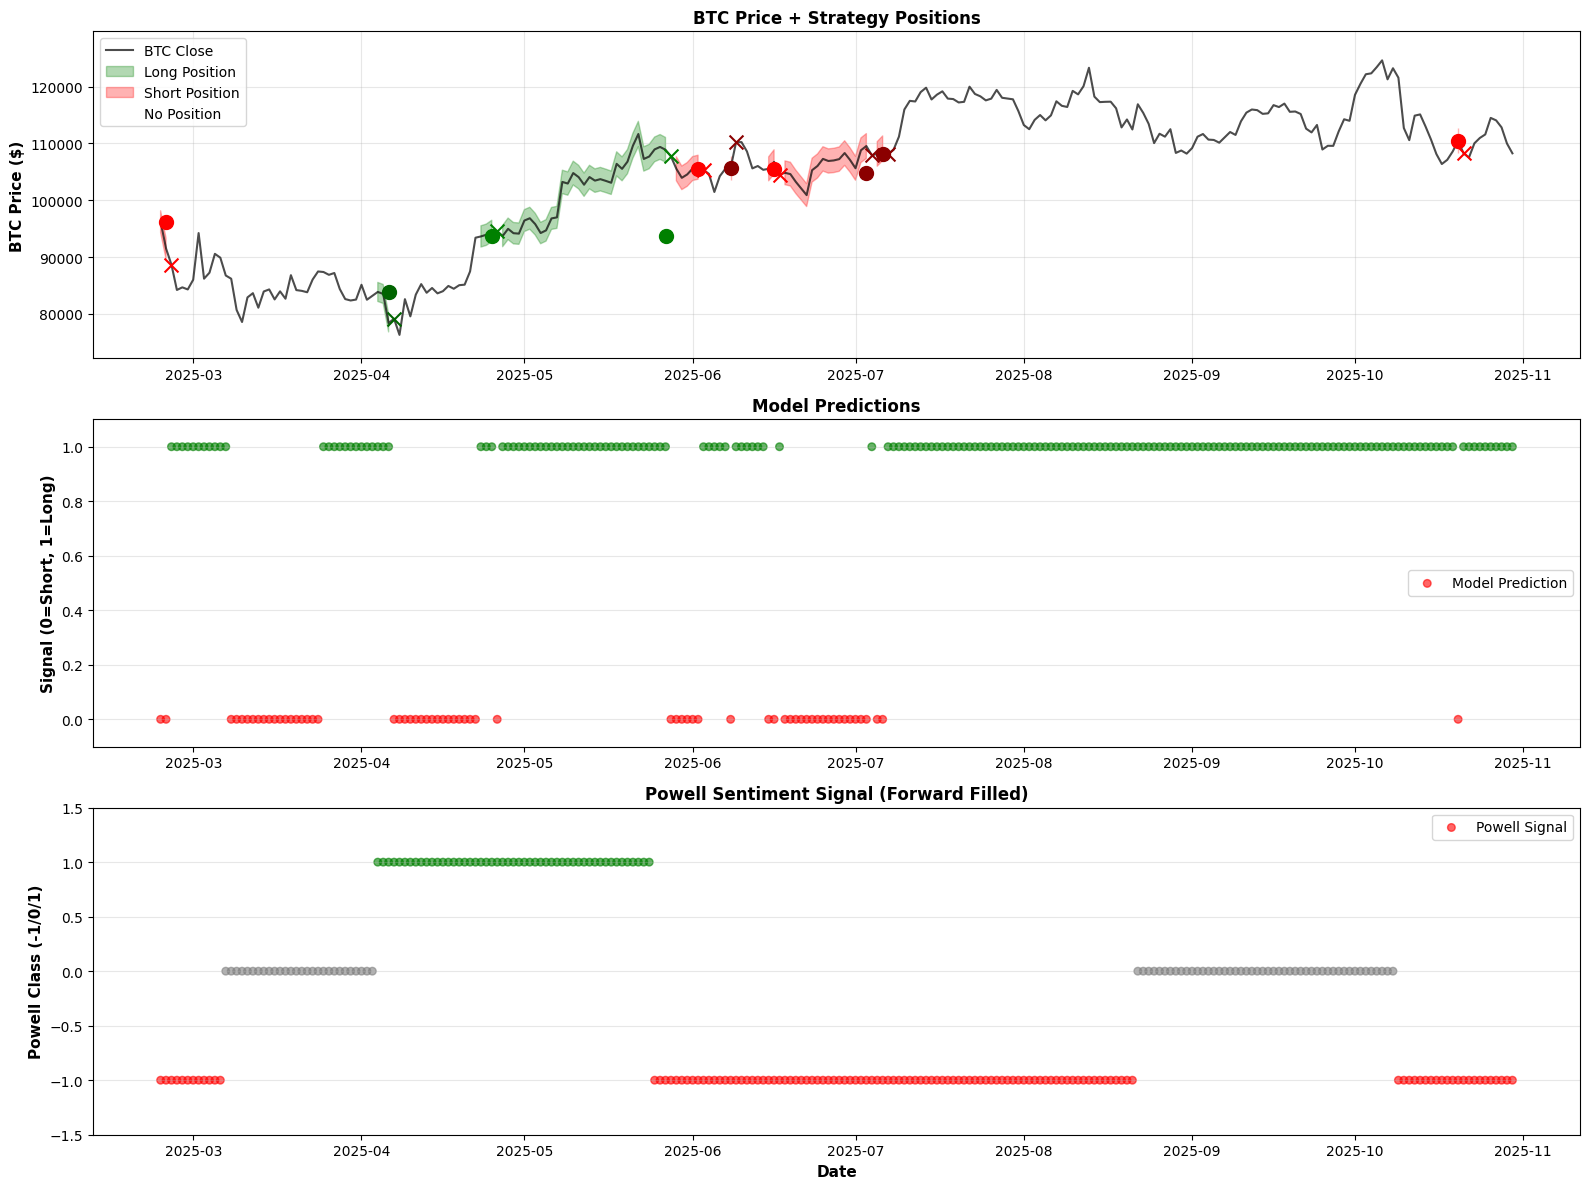

✓ Equity Curve salvo em data/equity_curve.png


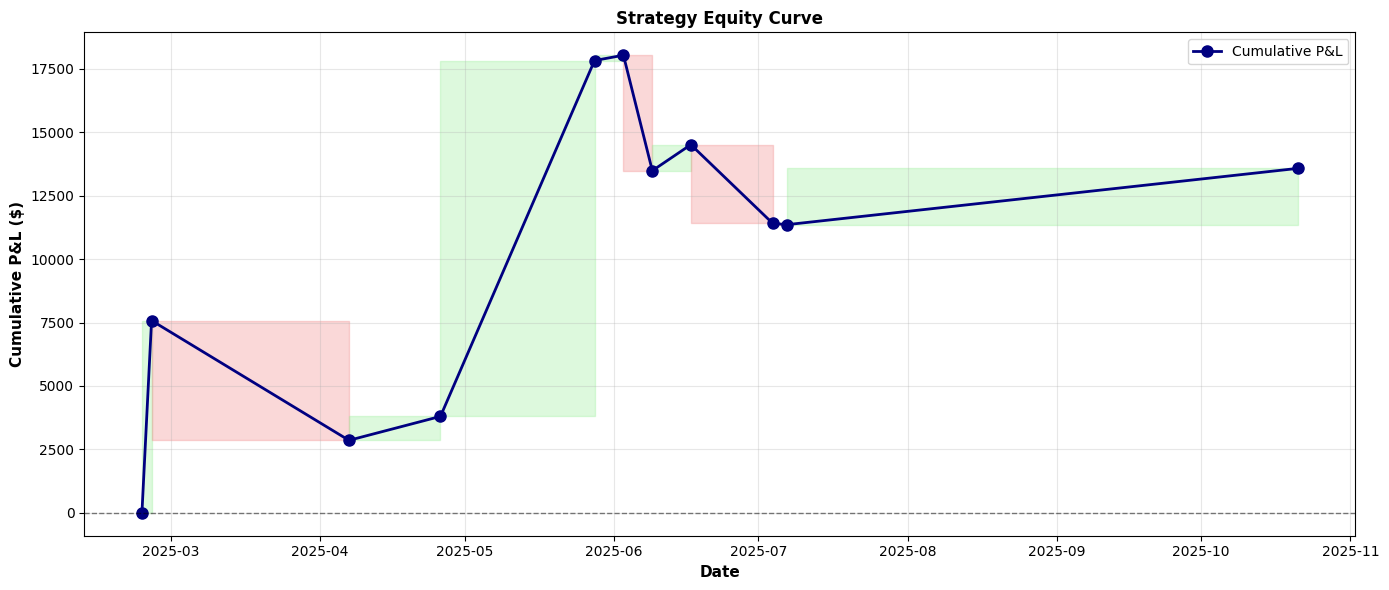

✓ Returns Distribution salvo em data/returns_distribution.png


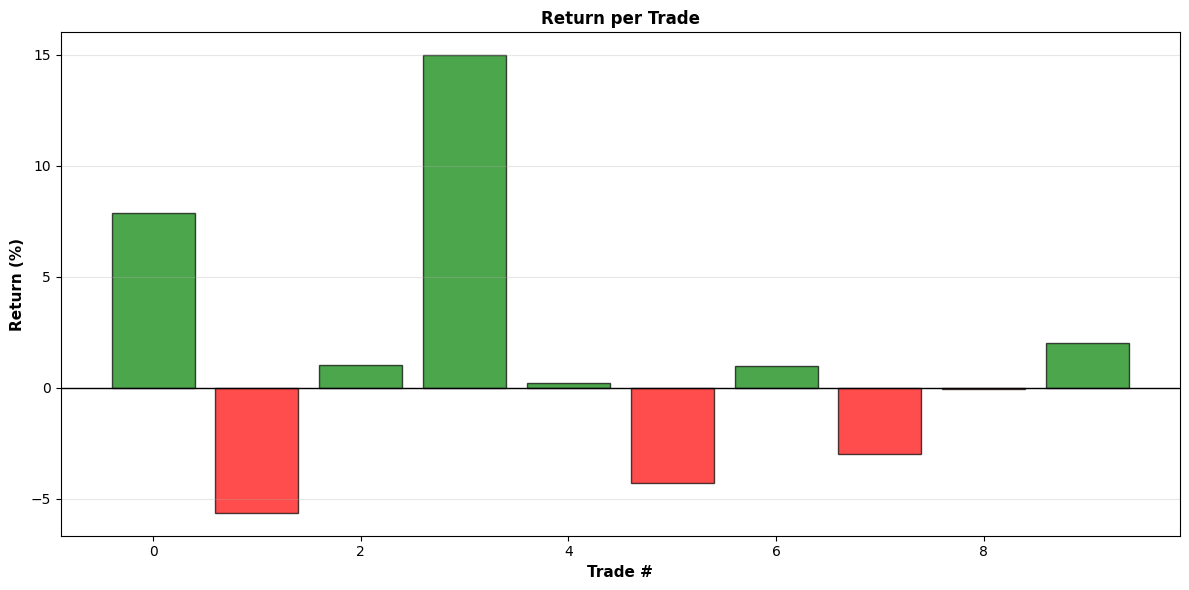


RESUMO ESTATÍSTICO DO BACKTEST

Totais:
  Total de Trades: 10
  Total P&L: $+13575.70
  Total Return: +14.11%

Win/Loss:
  Trades Vencedores: 6 (60.0%)
  Trades Perdedores: 4

P&L por Trade:
  Avg Win: $+4333.58 (+4.51%)
  Avg Loss: $-3106.45 (-3.24%)
  Max Win: $+14026.00
  Max Loss: $-4721.30

Razões:
  Profit Factor: 2.09
  Avg Win / Avg Loss: 1.40

Duração dos Trades:
  Média: 1.0 dias
  Min: 1 dias
  Max: 1 dias



In [ ]:
# Visualização de Resultados do Backtest

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle

# ============================================================================
# CARREGAR RESULTADOS
# ============================================================================

backtest_results = pd.read_csv(os.path.join(DATA_DIR, "backtest_results.csv"), parse_dates=["date"])
trades_results = pd.read_csv(os.path.join(DATA_DIR, "backtest_trades.csv"), parse_dates=["entry_date", "exit_date"])

print("Resultados carregados:")
print(f"  Dias analisados: {len(backtest_results)}")
print(f"  Trades executados: {len(trades_results)}")

# ============================================================================
# GRÁFICO 1: Preço BTC + Posições + Sinais Powell
# ============================================================================

fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# Eixo 1: Preço com positions
ax1 = axes[0]
dates = backtest_results["date"].values
closes = backtest_results["close"].values

ax1.plot(dates, closes, label="BTC Close", color="black", linewidth=1.5, alpha=0.7)

x = backtest_results["date"].values
y1 = closes * 0.98
y2 = closes * 1.02

long_mask  = backtest_results["position"] == 1
short_mask = backtest_results["position"] == -1
flat_mask  = backtest_results["position"] == 0

ax1.fill_between(x, y1, y2, where=long_mask,  color="green", alpha=0.3, label="Long Position")
ax1.fill_between(x, y1, y2, where=short_mask, color="red",   alpha=0.3, label="Short Position")
ax1.fill_between(x, y1, y2, where=flat_mask,  color="white", alpha=0.3, label="No Position")

# Marcar trades
for idx, trade in trades_results.iterrows():
    entry_price = trade["entry_price"]
    exit_price = trade["exit_price"]
    pnl = trade["pnl"]
    
    if trade["type"].startswith("LONG"):
        color = "green" if pnl > 0 else "darkgreen"
    else:
        color = "red" if pnl > 0 else "darkred"
    
    ax1.scatter(trade["entry_date"], entry_price, color=color, s=100, marker="o", zorder=5)
    ax1.scatter(trade["exit_date"], exit_price, color=color, s=100, marker="x", zorder=5)

ax1.set_ylabel("BTC Price ($)", fontsize=11, fontweight="bold")
ax1.set_title("BTC Price + Strategy Positions", fontsize=12, fontweight="bold")
ax1.legend(loc="upper left")
ax1.grid(True, alpha=0.3)

# Eixo 2: Sinais de Previsão
ax2 = axes[1]
colors_pred = ["red" if p == 0 else "green" for p in backtest_results["pred"]]
ax2.scatter(dates, backtest_results["pred"], c=colors_pred, s=30, alpha=0.6, label="Model Prediction")
ax2.set_ylabel("Signal (0=Short, 1=Long)", fontsize=11, fontweight="bold")
ax2.set_title("Model Predictions", fontsize=12, fontweight="bold")
ax2.set_ylim(-0.1, 1.1)
ax2.grid(True, alpha=0.3, axis="y")
ax2.legend()

# Eixo 3: Sinal Powell (Forward Filled)
ax3 = axes[2]
colors_powell = []
for p in backtest_results["powell_class"]:
    if p == 1:
        colors_powell.append("green")
    elif p == -1:
        colors_powell.append("red")
    else:
        colors_powell.append("gray")

ax3.scatter(dates, backtest_results["powell_class"], c=colors_powell, s=30, alpha=0.6, label="Powell Signal")
ax3.set_ylabel("Powell Class (-1/0/1)", fontsize=11, fontweight="bold")
ax3.set_xlabel("Date", fontsize=11, fontweight="bold")
ax3.set_title("Powell Sentiment Signal (Forward Filled)", fontsize=12, fontweight="bold")
ax3.set_ylim(-1.5, 1.5)
ax3.grid(True, alpha=0.3, axis="y")
ax3.legend()

plt.tight_layout()
plt.savefig(os.path.join(DATA_DIR, "backtest_analysis.png"), dpi=150, bbox_inches="tight")
print(f"\n✓ Gráfico salvo em {os.path.join(DATA_DIR, 'backtest_analysis.png')}")
plt.show()

# ============================================================================
# GRÁFICO 2: Equity Curve (Curva de Lucro Acumulado)
# ============================================================================

fig, ax = plt.subplots(figsize=(14, 6))

# Calcular equity curve baseado em trades
equity = [0]
trade_dates = [backtest_results["date"].iloc[0]]

for idx, trade in trades_results.iterrows():
    equity.append(equity[-1] + trade["pnl"])
    trade_dates.append(trade["exit_date"])

# Plotar equity curve
ax.plot(trade_dates, equity, marker="o", linewidth=2, markersize=8, color="navy", label="Cumulative P&L")
ax.axhline(y=0, color="black", linestyle="--", linewidth=1, alpha=0.5)

# Colorir fundo baseado em ganhos/perdas
for i in range(len(equity)-1):
    color = "lightgreen" if equity[i+1] > equity[i] else "lightcoral"
    ax.fill_between([trade_dates[i], trade_dates[i+1]], equity[i], equity[i+1], 
                    alpha=0.3, color=color)

ax.set_xlabel("Date", fontsize=11, fontweight="bold")
ax.set_ylabel("Cumulative P&L ($)", fontsize=11, fontweight="bold")
ax.set_title("Strategy Equity Curve", fontsize=12, fontweight="bold")
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.savefig(os.path.join(DATA_DIR, "equity_curve.png"), dpi=150, bbox_inches="tight")
print(f"✓ Equity Curve salvo em {os.path.join(DATA_DIR, 'equity_curve.png')}")
plt.show()

# ============================================================================
# GRÁFICO 3: Distribuição de Returns
# ============================================================================

fig, ax = plt.subplots(figsize=(12, 6))

returns = trades_results["return_pct"].values
colors_return = ["green" if r > 0 else "red" for r in returns]

bars = ax.bar(range(len(returns)), returns, color=colors_return, alpha=0.7, edgecolor="black")
ax.axhline(y=0, color="black", linestyle="-", linewidth=1)
ax.set_xlabel("Trade #", fontsize=11, fontweight="bold")
ax.set_ylabel("Return (%)", fontsize=11, fontweight="bold")
ax.set_title("Return per Trade", fontsize=12, fontweight="bold")
ax.grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.savefig(os.path.join(DATA_DIR, "returns_distribution.png"), dpi=150, bbox_inches="tight")
print(f"✓ Returns Distribution salvo em {os.path.join(DATA_DIR, 'returns_distribution.png')}")
plt.show()

# ============================================================================
# SUMÁRIO ESTATÍSTICO
# ============================================================================

print("\n" + "="*80)
print("RESUMO ESTATÍSTICO DO BACKTEST")
print("="*80)

if len(trades_results) > 0:
    # Métricas básicas
    total_trades = len(trades_results)
    total_pnl = trades_results["pnl"].sum()
    total_return_pct = (total_pnl / backtest_results["close"].iloc[0] * 100) if backtest_results["close"].iloc[0] > 0 else 0
    
    # Winning and losing trades
    winning = trades_results[trades_results["pnl"] > 0]
    losing = trades_results[trades_results["pnl"] < 0]
    n_wins = len(winning)
    n_losses = len(losing)
    win_rate = (n_wins / total_trades * 100) if total_trades > 0 else 0
    
    # P&L statistics
    avg_win = winning["pnl"].mean() if len(winning) > 0 else 0
    avg_loss = losing["pnl"].mean() if len(losing) > 0 else 0
    max_win = winning["pnl"].max() if len(winning) > 0 else 0
    max_loss = losing["pnl"].min() if len(losing) > 0 else 0
    
    # Return statistics
    avg_return_win = winning["return_pct"].mean() if len(winning) > 0 else 0
    avg_return_loss = losing["return_pct"].mean() if len(losing) > 0 else 0
    
    # Profit factor
    gross_profit = winning["pnl"].sum() if len(winning) > 0 else 0
    gross_loss = abs(losing["pnl"].sum()) if len(losing) > 0 else 0
    profit_factor = gross_profit / gross_loss if gross_loss > 0 else (float('inf') if gross_profit > 0 else 0)
    
    print(f"\nTotais:")
    print(f"  Total de Trades: {total_trades}")
    print(f"  Total P&L: ${total_pnl:+.2f}")
    print(f"  Total Return: {total_return_pct:+.2f}%")
    
    print(f"\nWin/Loss:")
    print(f"  Trades Vencedores: {n_wins} ({win_rate:.1f}%)")
    print(f"  Trades Perdedores: {n_losses}")
    
    print(f"\nP&L por Trade:")
    print(f"  Avg Win: ${avg_win:+.2f} ({avg_return_win:+.2f}%)")
    print(f"  Avg Loss: ${avg_loss:+.2f} ({avg_return_loss:+.2f}%)")
    print(f"  Max Win: ${max_win:+.2f}")
    print(f"  Max Loss: ${max_loss:+.2f}")
    
    print(f"\nRazões:")
    print(f"  Profit Factor: {profit_factor:.2f}" if profit_factor != float('inf') else f"  Profit Factor: ∞")
    if len(winning) > 0 and len(losing) > 0:
        print(f"  Avg Win / Avg Loss: {abs(avg_win / avg_loss):.2f}" if avg_loss != 0 else "  Avg Win / Avg Loss: ∞")
    
    print(f"\nDuração dos Trades:")
    trades_results["duration"] = (trades_results["exit_date"] - trades_results["entry_date"]).dt.days
    print(f"  Média: {trades_results['duration'].mean():.1f} dias")
    print(f"  Min: {trades_results['duration'].min()} dias")
    print(f"  Max: {trades_results['duration'].max()} dias")
else:
    print("Nenhum trade foi executado!")

print("\n" + "="*80)
